In [26]:
import os
import pandas as pd 
import numpy as np
from itertools import combinations
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
import pickle
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('credit_risk.csv')

#  Data Understanding

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    32581 non-null  int64  
 1   salary                 32581 non-null  int64  
 2   home_ownership         32581 non-null  object 
 3   employment_time        31686 non-null  float64
 4   loan_purposes          32581 non-null  object 
 5   credit_score           32581 non-null  object 
 6   Credit_Amount          32581 non-null  int64  
 7   loan_rate              29465 non-null  float64
 8   Credit_Status          32581 non-null  int64  
 9   loan_percentage        32581 non-null  float64
 10  Payment_History        32581 non-null  object 
 11  Credit_History_Length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [25]:
list(df.head(3).iloc[1,:])

[25, 25000, 'RENT', 0.0, 'MEDICAL', 'C', 8500, 12.53, 1, 0.34, 'Y', 2]

In [4]:
df.describe( include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,32581.0,NaN,NaN,NaN,27.7346,6.348078,20.0,23.0,26.0,30.0,144.0
salary,32581.0,NaN,NaN,NaN,66074.84847,61983.119168,4000.0,38500.0,55000.0,79200.0,6000000.0
home_ownership,32581,4,RENT,16446,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_time,31686.0,NaN,NaN,NaN,4.789686,4.14263,0.0,2.0,4.0,7.0,123.0
loan_purposes,32581,6,EDUCATION,6453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
credit_score,32581,7,A,10777,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Credit_Amount,32581.0,NaN,NaN,NaN,9589.371106,6322.086646,500.0,5000.0,8000.0,12200.0,35000.0
loan_rate,29465.0,NaN,NaN,NaN,11.011695,3.240459,5.42,7.9,10.99,13.47,23.22
Credit_Status,32581.0,NaN,NaN,NaN,0.218164,0.413006,0.0,0.0,0.0,0.0,1.0
loan_percentage,32581.0,NaN,NaN,NaN,0.170203,0.106782,0.0,0.09,0.15,0.23,0.83


In [5]:
# df[df['age'] == df['age'].max()]
df['age'].sort_values(ascending= False).head(10)

numeric_cols = list(df.select_dtypes(exclude= object))
numeric_cols.remove('Credit_Status')

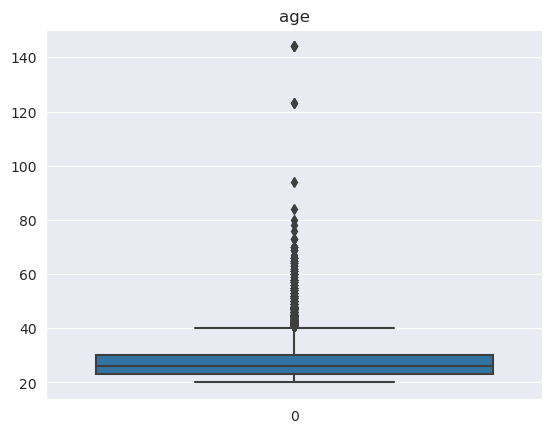

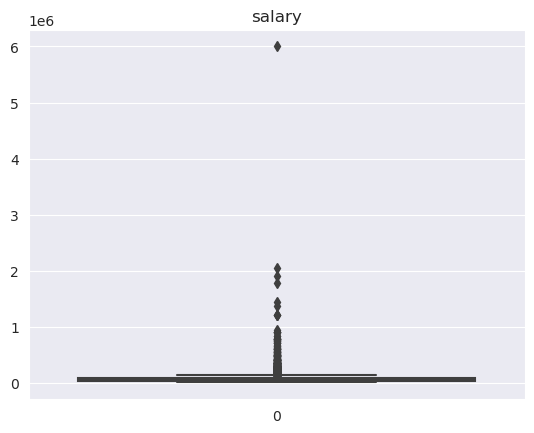

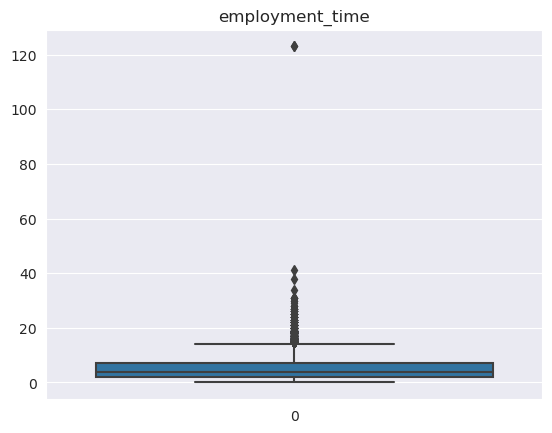

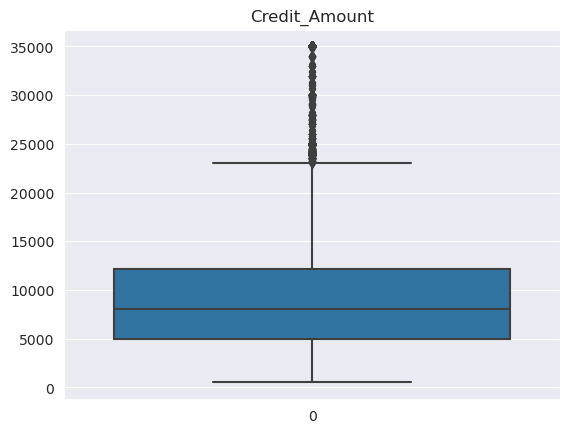

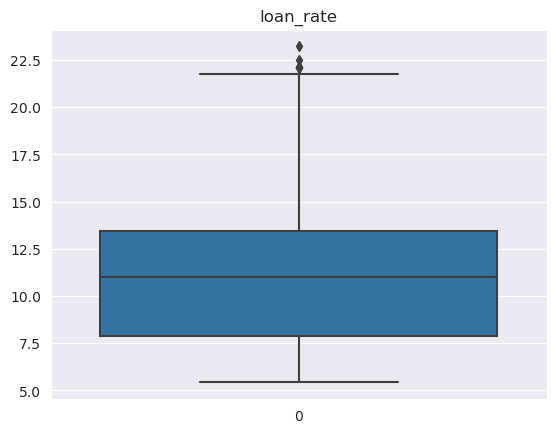

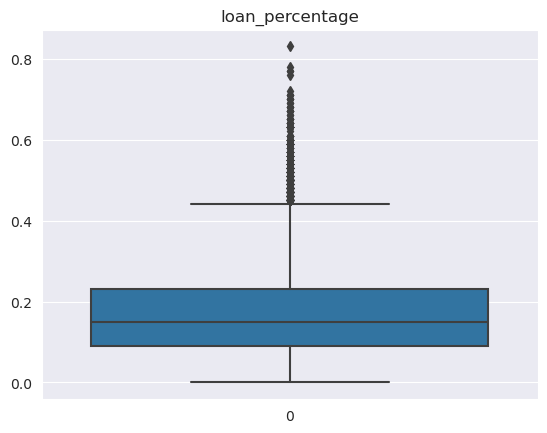

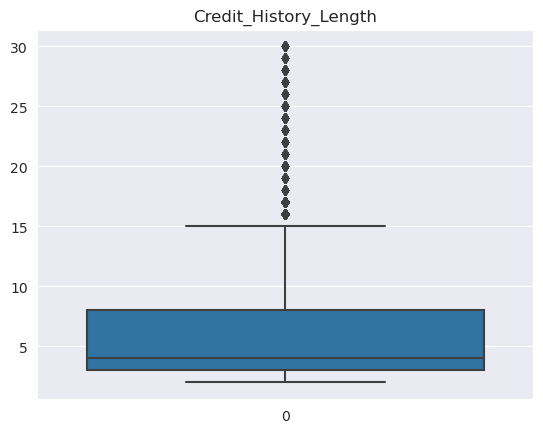

In [6]:
sns.set_style('darkgrid')
for i in numeric_cols:
    sns.boxplot(df[i])
    plt.title(i)
    plt.show()

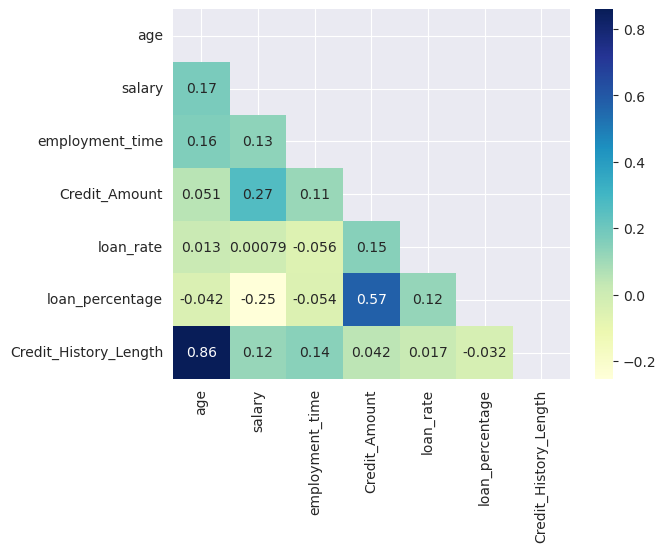

In [7]:
mask = np.triu(np.ones_like(df[numeric_cols].corr()))
 
# plotting a triangle correlation heatmap
dataplot = sns.heatmap(df[numeric_cols].corr(), cmap="YlGnBu", annot=True, mask=mask)
 
# displaying heatmap
plt.show()

In [8]:
# checking imbalance 
df['Credit_Status'].value_counts(normalize= True)

# 0 is more that 4 times than 1 ,there is Mild imbalace problem

Credit_Status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

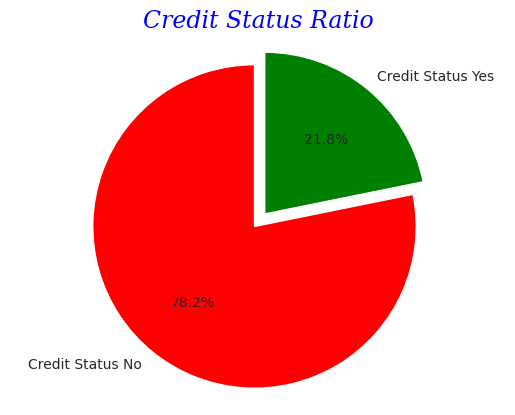

In [9]:
# pie chart
binary_ratio = df['Credit_Status'].mean()

# Visualize the ratio
labels = ['Credit Status No', 'Credit Status Yes']
sizes = [1 - binary_ratio, binary_ratio]
colors = ['red','green']
explode = (0, 0.1)

y = {'color':'b','fontfamily' : 'serif','fontstyle':'italic','fontsize': 17}
plt.pie(sizes, explode=explode, labels=labels , colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Credit Status Ratio',fontdict = y)
plt.show()

#  Data Preparation

In [10]:
# loan_purposes 95 % is null so we can drop it
# age ~ Credit_History_length ~ 0.86 correlation so we can drop it
del df['age']

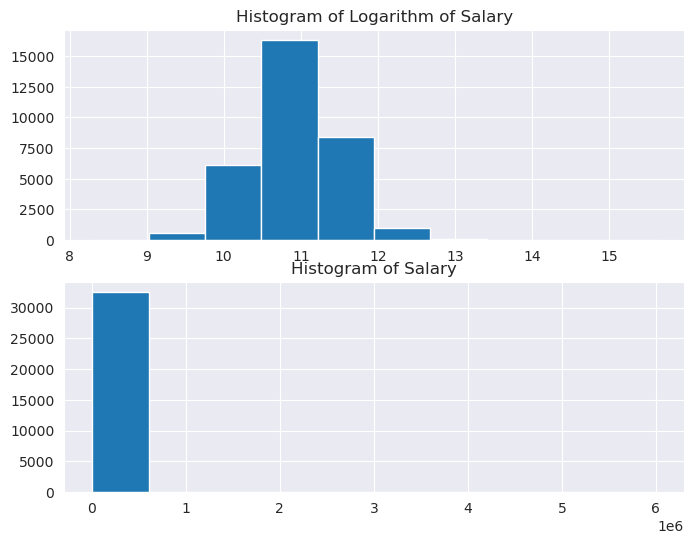

In [11]:
fig, axs = plt.subplots(2, 1,figsize=(8, 6))

# Plot on the first subplot (axs[0])
axs[0].hist(np.log(df['salary']))
axs[0].set_title('Histogram of Logarithm of Salary')

# Plot on the second subplot (axs[1])
axs[1].hist(df['salary'])
axs[1].set_title('Histogram of Salary')
plt.show()

In [12]:
# https://www.opploans.com/oppu/articles/grading-your-credit-score/
credict_score_dict = {'A':720,'B':690,'C':660,'D':630,'E':600,'F':570,'G':540}
df['credit_score'] = df['credit_score'].replace(credict_score_dict)

#change type of credit_score

df['credit_score'] = df['credit_score'].astype('int')

In [13]:
#Encoding of Payment_History
df['Payment_History'].replace({'N':0,'Y':1},inplace= True)
df['Payment_History'] = df['Payment_History'].astype('int')

In [14]:
cat_cols = [i for i in df.select_dtypes(object)]

In [15]:
for i in  cat_cols:
    print(i,df[i].nunique())

home_ownership 4
loan_purposes 6


In [16]:
def check_portion(data :pd.DataFrame,columns : list,taget : str):
    for i in  columns:
        print(data.groupby(by = i).agg({taget:'mean'}))


check_portion(df,cat_cols,'Credit_Status')



                Credit_Status
home_ownership               
MORTGAGE             0.125707
OTHER                0.308411
OWN                  0.074690
RENT                 0.315700
                   Credit_Status
loan_purposes                   
DEBTCONSOLIDATION       0.285879
EDUCATION               0.172168
HOMEIMPROVEMENT         0.261026
MEDICAL                 0.267007
PERSONAL                0.198877
VENTURE                 0.148103


In [17]:
def z_propotion_test(data, col, combination_number=2, target='Credit_Status',alpha = 0.05):
    unique_values = list(data[col].unique())
    for col_1, col_2 in combinations(unique_values, combination_number):
        group1_data = data[data[col] == col_1]
        group2_data = data[data[col] == col_2]

        # Number of successes in Group 1
        successes_group1 = len(group1_data[group1_data[target] == 0])
        sample_size_group1 = len(group1_data)

        # Number of successes in Group 2
        successes_group2 = len(group2_data[group2_data[target] == 0])
        sample_size_group2 = len(group2_data)

        # Calculate the sample proportions for each group
        prop1 = successes_group1 / sample_size_group1
        prop2 = successes_group2 / sample_size_group2

        # Perform the two-sample z-test for proportions
        count = np.array([successes_group1, successes_group2])
        nobs = np.array([sample_size_group1, sample_size_group2])
        z_stat, p_value = proportions_ztest(count, nobs)

        # Check if the p-value is less than the significance level
        if p_value > alpha:
            print("Fail to reject the Null Hypothesis. There is no significant difference between the proportions.", col_1, col_2)


# Test_of_Proposion_for_loan_purposes

In [18]:
z_propotion_test(df ,'home_ownership' ,2 )

Fail to reject the Null Hypothesis. There is no significant difference between the proportions. RENT OTHER


In [19]:
#check it manually
df[['home_ownership','Credit_Status']].groupby('home_ownership').mean().sort_values(by='Credit_Status',ascending=False)

,Credit_Status
home_ownership,
RENT,0.315700
OTHER,0.308411
MORTGAGE,0.125707
OWN,0.074690


In [20]:
grouped_elements_hm = ['RENT','OTHER']
df['home_ownership'] = df['home_ownership'].apply(lambda x: 'other_rent' if x in grouped_elements_hm else x)

In [21]:
#check it manually
df[['home_ownership','Credit_Status']].groupby('home_ownership').mean().sort_values(by='Credit_Status',ascending=False)

,Credit_Status
home_ownership,
other_rent,0.315653
MORTGAGE,0.125707
OWN,0.074690


# loan_purpose 

In [22]:
df.columns

Index(['salary', 'home_ownership', 'employment_time', 'loan_purposes',
       'credit_score', 'Credit_Amount', 'loan_rate', 'Credit_Status',
       'loan_percentage', 'Payment_History', 'Credit_History_Length'],
      dtype='object')

In [23]:
z_propotion_test(df ,'loan_purposes' ,2 )

Fail to reject the Null Hypothesis. There is no significant difference between the proportions. MEDICAL HOMEIMPROVEMENT


In [24]:
#check it manually
df[['loan_purposes','Credit_Status']].groupby('loan_purposes').mean().sort_values(by='Credit_Status',ascending=False)

,Credit_Status
loan_purposes,
DEBTCONSOLIDATION,0.285879
MEDICAL,0.267007
HOMEIMPROVEMENT,0.261026
PERSONAL,0.198877
EDUCATION,0.172168
VENTURE,0.148103


In [30]:
grouped_elements_lp = ['MEDICAL','HOMEIMPROVEMENT']
df['loan_purposes'] = df['loan_purposes'].apply(lambda x: 'MED_HOME' if x in grouped_elements_lp else x)

In [32]:
#check it manually
df[['loan_purposes','Credit_Status']].groupby('loan_purposes').mean().sort_values(by='Credit_Status',ascending=False)

,Credit_Status
loan_purposes,
DEBTCONSOLIDATION,0.285879
MED_HOME,0.264779
PERSONAL,0.198877
EDUCATION,0.172168
VENTURE,0.148103


# Target_Encoding

In [33]:
def Target_encoder(data :pd.DataFrame,columns : list,taget : str):
    colums_target_encoder = {}
    for i in  columns:
        colums_target_encoder[i] =  df.groupby(i)['Credit_Status'].mean().to_dict() 
    return colums_target_encoder


In [34]:
columns_target_encoder = Target_encoder(df,cat_cols,'Credit_Status')

In [45]:
columns_target_encoder

{'home_ownership': {'MORTGAGE': 0.12570663493008033,
  'OWN': 0.07469040247678019,
  'other_rent': 0.31565275176705127},
 'loan_purposes': {'DEBTCONSOLIDATION': 0.28587874136607827,
  'EDUCATION': 0.17216798388346505,
  'MED_HOME': 0.26477883422902027,
  'PERSONAL': 0.1988770150335084,
  'VENTURE': 0.1481028151774786}}

In [46]:
df['home_ownership'] = df['home_ownership'].map(columns_target_encoder['home_ownership'])

In [47]:
df['loan_purposes'] = df['loan_purposes'].map(columns_target_encoder['loan_purposes'])

# feature engineering

In [48]:
print(f"Transformed_data_correlation :{np.log(df['salary']).corr(df['Credit_Status'])} original_data_correlation : {df['salary'].corr(df['Credit_Status'])}")
df['salary'] = pd.Series(np.log(df['salary']))

Transformed_data_correlation :-0.2828097042416443 original_data_correlation : -0.1444494882345536


# Null values imputation

<Axes: title={'center': 'Missing Values'}>

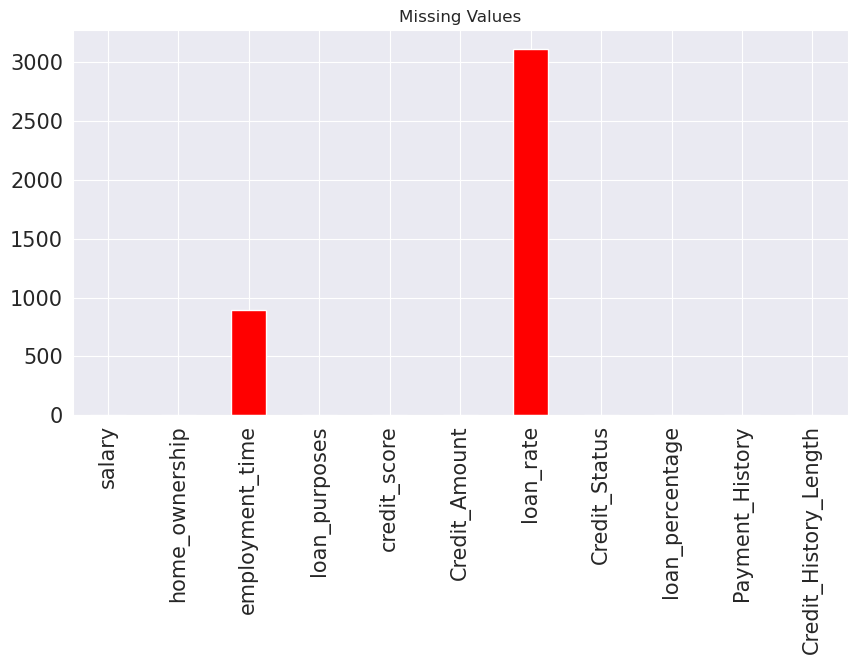

In [49]:
df.isnull().sum().plot(kind='bar',figsize=(10,5),color='red',title='Missing Values',fontsize=15)

In [50]:
mice =  IterativeImputer(
        estimator=RandomForestRegressor(),
        sample_posterior=False,
        max_iter=10,
        tol=0.001,
        imputation_order='ascending',
        skip_complete=False,
        verbose=0,
        random_state= 0,
        add_indicator=False,)

In [51]:
columns = ['salary',
 'home_ownership',
 'employment_time',
 'loan_purposes',
 'credit_score',
 'Credit_Amount',
 'loan_rate',
 'Credit_Status',
 'loan_percentage',
 'Payment_History',
 'Credit_History_Length']

In [52]:
df = pd.DataFrame(mice.fit_transform(df),columns= df.columns)

In [53]:
df.isnull().sum()

salary                   0
home_ownership           0
employment_time          0
loan_purposes            0
credit_score             0
Credit_Amount            0
loan_rate                0
Credit_Status            0
loan_percentage          0
Payment_History          0
Credit_History_Length    0
dtype: int64

In [54]:
df.to_csv('cleaned_data.csv',index=False,header=True)

In [55]:
scale = StandardScaler()
scale = scale.fit(df.drop('Credit_Status',axis=1))  
scaled_features = scale.transform(df.drop('Credit_Status',axis=1))


In [56]:
# Save the trained scaler using pickle
with open('scale.pkl', 'wb') as file:
    pickle.dump(scale, file)


In [57]:
with open('scale.pkl', 'rb') as file:
    scale_transform = pickle.load(file)

In [58]:
data = pd.DataFrame(scale.transform(df.drop('Credit_Status',axis=1)) , columns=df.drop('Credit_Status',axis=1).columns)

In [59]:
data['Credit_Status'] = df['Credit_Status']

In [60]:
df = pd.read_csv('cleaned_data.csv')

In [61]:
# squueze outlier in  the data between -3 and 3
for i in df:
    df[i] = df[i].apply( lambda value : value if value < 3 and value > -3 else ( 3 if value > 3 else -3))

In [ ]:
df.to_csv('cleaned_data.csv',index=False,header=True)

In [69]:
scale_transform.transform([[1,20,10,3,1,2,3,4,5,5]])

array([[-17.53118759, 197.93210127,   1.2730824 ,  53.31472425,
        -19.50452033,  -1.51651168,  -2.48652194,  35.86619487,
         12.65721368,  -0.19832877]])

In [8]:
pd.read_csv('cleaned_data.csv').columns

Index(['salary', 'home_ownership', 'employment_time', 'loan_purposes',
       'credit_score', 'Credit_Amount', 'loan_rate', 'loan_percentage',
       'Payment_History', 'Credit_History_Length', 'Credit_Status'],
      dtype='object')